## Optimization

---

### **1. Introduction – Why Do We Need Optimization?**

In the previous notebooks, we learned how neural networks make predictions using **linear transformations** and **non-linear activations**.  
We also learned how to **quantify errors** using **cross-entropy loss**.

But one crucial piece remains:

> ❓ How do we **train** our model to minimize that loss?

The answer lies in a powerful concept:  
🎯 **Optimization** — the art of adjusting parameters (weights and biases) to make better predictions.

>**The Goal of Optimization**

Every model has **parameters** (like weights in a neural network).  
During training, we want to **adjust these parameters** to **minimize the loss** on our dataset.

Mathematically:

$$
\min_{\theta} \ \mathcal{L}(\theta)
$$

Where:
- $\theta$ = parameters of the model
- $\mathcal{L}(\theta)$ = loss function (e.g., cross-entropy)

This is where **gradient-based optimization** comes in.

>**The Idea of a Loss Surface**

Imagine a hilly landscape — valleys and mountains.  
Each point on this surface corresponds to a different set of model parameters.  
Our goal is to **descend** to the lowest point — the global (or local) **minimum** of the loss.


> The **loss surface** is often very complex, especially for deep networks — with many bumps and valleys.


>**Gradient Descent – A Quick Intuition**

Gradient Descent is an algorithm to "walk downhill" the loss surface.

Each update looks like:

$$
\theta := \theta - \eta \cdot \nabla_\theta \mathcal{L}
$$

Where:
- $\eta$ = learning rate (step size)
- $\nabla_\theta \mathcal{L}$ = gradient of loss w.r.t parameters

> **🚦 But Wait... Which Gradient?**

This leads to different **variants** of Gradient Descent based on how we compute the gradient:

| Method               | How Gradient is Computed                 | Speed      | Stability | Memory |
|----------------------|------------------------------------------|------------|-----------|--------|
| **Batch Gradient Descent** | Use the **entire dataset** to compute gradient | Slow        | Stable    | High   |
| **Stochastic Gradient Descent (SGD)** | Use **1 random sample** at a time           | Fast updates | Noisy     | Low    |
| **Mini-batch SGD**   | Use **a few samples (batch)**            | Good tradeoff | Balanced  | Medium |

We’ll explore these in detail with code and plots.

>🔍 What You'll Learn in This Notebook

- How different optimizers behave on real training data
- How **batch size** affects training speed and accuracy
- How to **interpret training curves** (loss/accuracy over epochs)
- When to choose **SGD vs. Mini-Batch SGD vs. Full GD**


➡️ In the next section, we’ll load the **Yeast protein localization dataset**  
and get it ready for our experiments.

---

### **2. Dataset Setup**

Before comparing optimizers, we need to properly load and prepare our **Yeast protein localization dataset**.

We'll go through the following steps:
1. Load the CSV file using `pandas`.
2. Encode the **target labels** using `LabelEncoder`.
3. Standardize the **input features** using `StandardScaler`.
4. Split the dataset into **training** and **testing** sets.
5. Convert the arrays to **PyTorch tensors** and wrap them with `DataLoader`.


> 💡 Why These Steps?

- **Label Encoding** is required because neural networks expect integer targets for classification.
- **Feature Scaling** is crucial because it makes training more stable and faster.
- **Train/Test Split** helps evaluate how well our model generalizes to unseen data.
- **Tensors + DataLoader** are PyTorch’s way of efficiently feeding data during training.

Let’s implement each step carefully.

## Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import TensorDataset, DataLoader

In [2]:
df = pd.read_csv('yeast.csv')
# rename target variable
df.rename(columns={'name' : 'localization_site'}, inplace=True)

# split into X and y (predictors) and (predicted or target variables)
target = 'localization_site'
X, y = df.drop(target, axis=1), df[target]

# Encode target variables
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
labels = label_encoder.classes_

# standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Convert to pytorch tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Wrap in a DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, shuffle=True, batch_size=32)

# Check shapes and class info
print("✅ Train set:", X_train_tensor.shape)
print("✅ Test set:", X_test_tensor.shape)
print("✅ Number of Classes:", len(labels))
print("✅ Class Names:", labels)

✅ Train set: torch.Size([1187, 8])
✅ Test set: torch.Size([297, 8])
✅ Number of Classes: 10
✅ Class Names: ['CYT' 'ERL' 'EXC' 'ME1' 'ME2' 'ME3' 'MIT' 'NUC' 'POX' 'VAC']


**✅ Code Task 3.3.2.1: Class Distribution Check**

📘 Instruction:
Check the number of samples in each class in y_train_tensor using torch.bincount(). Print the result as a dictionary.

In [3]:
CT_class_count = torch.bincount(y_train_tensor)

print("CT_Class Distribution:")
for i, count in enumerate(CT_class_count):
    print(f'{labels[i]} : {count}')

CT_Class Distribution:
CYT : 370
ERL : 4
EXC : 28
ME1 : 35
ME2 : 41
ME3 : 131
MIT : 195
NUC : 343
POX : 16
VAC : 24


---

### **3. Model Definition — Building Our MLP**

Now that our data is ready, let's define a simple **Multi-Layer Perceptron (MLP)** using PyTorch.

We’ll use the same architecture as in NB02, so that we can attribute any performance changes purely to the optimizer behavior — not model changes.

This consistency ensures a **fair comparison**.

---

>Architecture Overview

- **Input Layer:** 8 features from the yeast dataset.
- **Hidden Layer:** 32 neurons, ReLU activation.
- **Output Layer:** 10 neurons (one for each class), no activation here — we’ll use `CrossEntropyLoss` which applies `LogSoftmax` internally.

>✅ Why ReLU?

ReLU is a widely used activation function in neural networks due to its simplicity and efficiency:

$$
\text{ReLU}(x) = 
\begin{cases} 
0 & \text{if } x < 0 \\
x & \text{otherwise}
\end{cases}
$$

It introduces non-linearity and mitigates the vanishing gradient problem better than sigmoid or tanh in many cases.

>🧱 Implementation

We'll use `nn.Sequential` for simplicity — it stacks layers linearly.

We define a custom `YeastMLP` class to encapsulate our network and provide a clear forward method.

>🧪 Output

Once the model is defined, we print its structure to verify all layers and parameter counts.

In [4]:
class YeastMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.model(x)


input_dim = X_train_tensor.shape[1]
hidden_dim = 16
output_dim = len(labels)

model = YeastMLP(input_dim, hidden_dim, output_dim)

print(model)

YeastMLP(
  (model): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
)


In [5]:
sum(p.numel() for p in model.parameters())

314

---

### **4. Optimizers Overview — GD vs. SGD vs. Mini-Batch**

Now that we’ve built our model, let’s understand how we train it — specifically, how we optimize its weights to reduce the loss.

In neural networks, we use **gradient-based optimization**. The most common approach is **Stochastic Gradient Descent (SGD)** and its variants.

But what does that really mean?

Let’s explore three core optimization strategies:

>**🌐 1. Gradient Descent (Full-Batch)**

- Uses **all training data** to compute the gradient.
- **Very stable**, but **slow and memory-intensive**.
- Gradient direction is exact but computation is expensive for large datasets.

>Update Rule

Let $ \theta $ be model parameters, $ \eta $ the learning rate:

$$
\theta = \theta - \eta \cdot \nabla J(\theta) \quad \text{where } J(\theta) = \text{loss on entire dataset}
$$

>**🔄 2. Stochastic Gradient Descent (SGD)**

- Uses **one sample at a time** to compute the gradient.
- **Very fast**, but **noisy updates**.
- Faster learning but erratic convergence.

>Update Rule

$$
\theta = \theta - \eta \cdot \nabla J(\theta^{(i)}) \quad \text{where } J(\theta^{(i)}) = \text{loss on single sample}
$$

>**📦 3. Mini-Batch SGD**

- Compromise: use **small batches** (e.g., 32 samples).
- **Balances speed and stability**.
- Widely used in practice.

>📉 Update Rule

$$
\theta = \theta - \eta \cdot \nabla J(\theta^{(i:i+k)}) \quad \text{for a mini-batch of } k \text{ samples}
$$

> **🌍 Optimizer Landscape**

| Optimizer | Gradient Computation | Update Frequency | Pros | Cons |
|----------|----------------------|------------------|------|------|
| **Gradient Descent (GD)** | Uses *all* training data | Once per epoch | Stable updates | Slow, memory-heavy |
| **Stochastic Gradient Descent (SGD)** | Uses *one sample* at a time | Per sample | Fast, frequent updates | Noisy, unstable |
| **Mini-Batch SGD** | Uses *a small batch* | Per mini-batch | Balance of both worlds | Hyperparameter tuning needed |

>Why Does This Matter?
- Each optimizer affects **convergence speed**, **stability**, and **generalization**.
- We’ll compare them side-by-side in upcoming sections.

> **🧠 Summary**

- **Full-Batch GD** is deterministic but slow.
- **SGD** is fast and noisy — good for large datasets, but can oscillate.
- **Mini-Batch SGD** is widely used — it balances **speed** and **stability**.

🔔 We’ll now implement and compare these three approaches — using the **same model and dataset** for a fair comparison.

---

### **5. Implement Full-Batch Gradient Descent**

We’ll implement the **simplest optimization strategy** — **full-batch gradient descent** — from scratch using PyTorch. This means:

- At each epoch, we compute the gradients over the **entire training set**.
- Then we update all model parameters **once per epoch**.

This helps us:

- Understand what happens behind the scenes during training.
- Build a clean baseline to compare with more advanced optimizers (SGD, Mini-Batch SGD).
- Observe what happens when gradients are averaged over **all data**.

>✅ What We’ll Do

- Use the **same MLP model** we defined earlier.
- For each epoch:
  1. Perform a **forward pass** over the whole training set.
  2. Compute the **loss** using cross-entropy.
  3. Manually compute **gradients** via `loss.backward()`.
  4. Update parameters with a simple optimizer step.
  5. Track **loss** and **accuracy** over time.

In [6]:
# set seed for reproducibility

torch.manual_seed(42)

mode_gd = YeastMLP(input_dim, hidden_dim, output_dim)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.1)

# store loss and accuracy per epoch
train_loss_gd = []
train_acc_gd  = []

# define number of epochs
num_epochs = 100

start_time = time.perf_counter()

for epoch in range(num_epochs):
    # set model in training model
    model.train()

    logits = model(X_train_tensor)
    loss = loss_fn(logits, y_train_tensor)

    # Backward Propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss_gd.append(loss.item())

    # compute accuracy
    preds = torch.argmax(logits, dim=1)
    acc = (preds == y_train_tensor).float().mean().item()
    train_acc_gd.append(acc)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:>2} | Loss: {loss.item():.4f} | Accuracy: {acc*100:.2f}%")

end_time = time.perf_counter()
print(f'Training Completed in {end_time -start_time:.2f} seconds')

Epoch 10 | Loss: 2.0316 | Accuracy: 28.14%
Epoch 20 | Loss: 1.8681 | Accuracy: 29.06%
Epoch 30 | Loss: 1.7342 | Accuracy: 30.92%
Epoch 40 | Loss: 1.6235 | Accuracy: 36.06%
Epoch 50 | Loss: 1.5334 | Accuracy: 40.86%
Epoch 60 | Loss: 1.4596 | Accuracy: 46.25%
Epoch 70 | Loss: 1.3985 | Accuracy: 48.95%
Epoch 80 | Loss: 1.3470 | Accuracy: 50.97%
Epoch 90 | Loss: 1.3038 | Accuracy: 53.24%
Epoch 100 | Loss: 1.2674 | Accuracy: 54.17%
Training Completed in 0.22 seconds


>What To Look For

- Is the **loss steadily decreasing** over epochs?
- Is the **accuracy improving** or plateauing?
- How **fast or slow** is this approach?

📌 **Reminder**: Full-batch GD is computationally expensive for large datasets.  
But for small datasets like ours, it's useful as a **baseline** optimizer.

➡️ In the next section, we’ll implement **Stochastic Gradient Descent**, where we update weights **after every single training sample** — a much noisier, faster approach.

---

**✅ Code Task 3.3.5.1: Manual One-Epoch Full-Batch GD**

📘 Instruction:
Initialize a fresh model and perform one epoch of full-batch GD on the entire training data. Print the loss and accuracy.

In [7]:
# Task 2 – One epoch of full-batch GD
CT_model_gd = YeastMLP(input_dim, hidden_dim, output_dim)
CT_loss_fn = nn.CrossEntropyLoss()
CT_optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Forward pass
CT_logits = CT_model_gd(X_train_tensor)
CT_loss = CT_loss_fn(CT_logits, y_train_tensor)

# Backward pass
CT_optimizer.zero_grad()
CT_loss.backward()
CT_optimizer.step()

# Accuracy
CT_preds = torch.argmax(CT_logits, dim=1)
CT_acc = (CT_preds == y_train_tensor).float().sum().item() / 100

print(f"CT_OneEpoch Loss: {CT_loss.item():.4f}")
print(f"CT_OneEpoch Accuracy: {CT_acc:.4f}")


CT_OneEpoch Loss: 2.4156
CT_OneEpoch Accuracy: 0.5400


---

### **6. Implement Stochastic Gradient Descent (SGD)**

We’ll now implement **Stochastic Gradient Descent (SGD)**, where the model updates its weights **after every single training sample**, instead of after seeing the entire dataset.

>🔍 Why Use SGD?

- Faster updates = potentially **faster convergence**.
- Introduces **randomness**, which can help escape local minima.
- Much more scalable for large datasets.

But also:
- Loss curve can be **noisier**.
- Updates based on single samples are less stable.

>**🔁 Key Differences from Full-Batch GD**

| Feature                | Full-Batch GD             | Stochastic GD             |
|------------------------|---------------------------|----------------------------|
| Update Frequency       | Once per epoch            | Once per sample            |
| Computation per step   | High (all samples)        | Low (1 sample)             |
| Noise in updates       | Low (averaged gradients)  | High (individual gradients)|
| Convergence behavior   | Smooth but slow           | Fast but noisy             |

>🔄 Implementation Steps

1. **Shuffle** the training data at each epoch.
2. Loop through each training example:
   - Compute forward pass.
   - Compute loss.
   - Backpropagate and update weights.
   - Reset gradients after each update.

📌 We’ll use PyTorch’s standard tools but **manually loop through samples**.

In [10]:
import random

# set manual seed
torch.manual_seed(42)

model_sgd = YeastMLP(input_dim=X_test_tensor.shape[1], hidden_dim=16, output_dim=len(labels))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_sgd.parameters(), lr=0.01)

# track metrics
sgd_loss_values = []
sgd_acc_values = []

# convert train set into list of samples
train_samples = list(zip(X_train_tensor, y_train_tensor))

start_time = time.perf_counter()

for epoch in range(100):
    epoch_loss = 0
    correct = 0

    # shuffling training samples
    torch.random.manual_seed(epoch)
    shuffled_samples = train_samples.copy()
    random.shuffle(shuffled_samples)

    for x_sample, y_sample in shuffled_samples:
        x_sample = x_sample.unsqueeze(0)
        y_sample = y_sample.unsqueeze(0)

        # forward pass
        logits = model_sgd(x_sample)
        loss = criterion(logits, y_sample)

        # parameters update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #track loss and accuracy
        epoch_loss += loss.item()
        _, predicted = torch.max(logits.data, 1)
        correct += (predicted == y_sample).sum().item()

    avg_loss = epoch_loss / len(train_samples)
    accuracy = correct / len(train_dataset)

    sgd_loss_values.append(avg_loss)
    sgd_acc_values.append(accuracy)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:>2} | Loss: {avg_loss:.4f} | Accuracy: {accuracy*100:.2f}%")

end_time = time.perf_counter()
print(F"Training completed in {end_time - start_time} seconds")

Epoch 10 | Loss: 1.0291 | Accuracy: 60.74%
Epoch 20 | Loss: 1.0036 | Accuracy: 62.43%
Epoch 30 | Loss: 0.9798 | Accuracy: 61.58%
Epoch 40 | Loss: 0.9670 | Accuracy: 61.92%
Epoch 50 | Loss: 0.9579 | Accuracy: 63.35%
Epoch 60 | Loss: 0.9521 | Accuracy: 63.77%
Epoch 70 | Loss: 0.9438 | Accuracy: 62.85%
Epoch 80 | Loss: 0.9298 | Accuracy: 63.86%
Epoch 90 | Loss: 0.9297 | Accuracy: 64.11%
Epoch 100 | Loss: 0.9221 | Accuracy: 65.04%
Training completed in 73.0506918079991 seconds


➡️ Next, we’ll scale this up by processing samples in **mini-batches**.

---

**✅ Code Task 3.3.6.1: One-Epoch SGD (Stochastic)**

📘 Instruction:
Train the model for one epoch using stochastic gradient descent, updating weights after every sample. Print the average loss and accuracy.

In [11]:
# Task 3 – One epoch of SGD
CT_model_sgd = YeastMLP(input_dim, hidden_dim, output_dim)
CT_criterion = nn.CrossEntropyLoss()
CT_optimizer = torch.optim.SGD(CT_model_sgd.parameters(), lr=0.01)

# Prepare samples
CT_train_samples = list(zip(X_train_tensor, y_train_tensor))

random.shuffle(CT_train_samples)

CT_total_loss = 0.0
CT_correct = 0

for x_sample, y_sample in CT_train_samples:
    x_sample = x_sample.unsqueeze(0)
    y_sample = y_sample.unsqueeze(0)

    CT_outputs = CT_model_sgd(x_sample)
    CT_loss = CT_criterion(CT_outputs, y_sample)

    CT_optimizer.zero_grad()
    CT_loss.backward()
    CT_optimizer.step()

    _, preds = torch.max(CT_outputs.data, 1)

    CT_total_loss += CT_loss.item()
    CT_correct += (preds == y_sample).sum().item()

CT_avg_loss = CT_total_loss / len(y_train_tensor)
CT_acc = CT_correct / len(train_dataset)

print(f"CT_SGD One Epoch | Avg Loss: {CT_avg_loss:.4f} | Accuracy: {CT_acc:.4f}")


CT_SGD One Epoch | Avg Loss: 1.5883 | Accuracy: 0.4069


---

### **7. Implement Mini-Batch SGD**

Now, we will learn how to train the model using **mini-batch gradient descent** — a practical middle ground between full-batch and per-sample updates.

>Why Mini-Batch?

We’ve already seen:

- **GD (batch)**: Stable but slow, processes all data at once.
- **SGD (per-sample)**: Faster updates, but noisy.

**Mini-batch SGD** strikes a balance:
- Updates are more stable than SGD
- More efficient than full-batch (especially on GPUs)

>🧠 How It Works (Intuition)

We break the training data into small **batches** (e.g., size 32), and for each batch:

1. Do forward pass  
2. Compute loss  
3. Backpropagate  
4. Update weights  

Repeat this for all batches in the epoch.

>🧱 Architecture and Logic

We’ll use PyTorch’s `DataLoader` to create mini-batches:

- Handles shuffling
- Automatically batches the data
- Makes training cleaner

In [12]:
epochs = 100
learning_rate = 0.01
batch_size = 32

model_mb = YeastMLP(input_dim=X_train_tensor.shape[1], hidden_dim=16, output_dim=len(labels))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_mb.parameters(), lr = learning_rate)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

start_time = time.perf_counter()
# store metrics
losses_mb = []
accs_mb = []
for epoch in range(epochs):
    model_mb.train()
    epoch_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        # forward pass
        outputs = model_mb(X_batch)
        loss = criterion(outputs, y_batch)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # track loss
        epoch_loss += loss.item() * X_batch.size(0)

        # track predictions and accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    avg_loss = epoch_loss / total
    acc = correct / total

    losses_mb.append(avg_loss)
    accs_mb.append(acc)

    print(f"[Mini-Batch] Epoch {epoch+1:2d}: Loss = {avg_loss:.4f} | Accuracy = {acc:.4f}")

end_time = time.perf_counter()
print(F"Training time {end_time - start_time} seconds")

[Mini-Batch] Epoch  1: Loss = 2.3321 | Accuracy = 0.0489
[Mini-Batch] Epoch  2: Loss = 2.2290 | Accuracy = 0.1407
[Mini-Batch] Epoch  3: Loss = 2.1365 | Accuracy = 0.3176
[Mini-Batch] Epoch  4: Loss = 2.0533 | Accuracy = 0.3631
[Mini-Batch] Epoch  5: Loss = 1.9776 | Accuracy = 0.3850
[Mini-Batch] Epoch  6: Loss = 1.9068 | Accuracy = 0.3858
[Mini-Batch] Epoch  7: Loss = 1.8410 | Accuracy = 0.4044
[Mini-Batch] Epoch  8: Loss = 1.7810 | Accuracy = 0.4094
[Mini-Batch] Epoch  9: Loss = 1.7233 | Accuracy = 0.4162
[Mini-Batch] Epoch 10: Loss = 1.6713 | Accuracy = 0.4195
[Mini-Batch] Epoch 11: Loss = 1.6208 | Accuracy = 0.4297
[Mini-Batch] Epoch 12: Loss = 1.5741 | Accuracy = 0.4600
[Mini-Batch] Epoch 13: Loss = 1.5310 | Accuracy = 0.4634
[Mini-Batch] Epoch 14: Loss = 1.4916 | Accuracy = 0.4735
[Mini-Batch] Epoch 15: Loss = 1.4562 | Accuracy = 0.4937
[Mini-Batch] Epoch 16: Loss = 1.4239 | Accuracy = 0.5046
[Mini-Batch] Epoch 17: Loss = 1.3949 | Accuracy = 0.5147
[Mini-Batch] Epoch 18: Loss = 1

>Benefits Recap

- Faster convergence than full-batch  
- Less noise than SGD  
- Scalable with large datasets  
- GPU-friendly via batching

Mini-batch training is the go-to method in deep learning:

- Efficient parallelism  
- Better generalization (some noise helps escape local minima)  
- Works well with vectorized hardware (e.g., GPUs)

➡️ In the next section, we’ll **compare all three optimizers** (GD, SGD, Mini-Batch) in terms of speed and accuracy.

---

**✅ Code Task 3.3.7.1: One-Epoch Mini-Batch SGD**

📘 Instruction:
Run a single epoch of training using mini-batch SGD (batch size = 32). Print the average loss and accuracy.

In [14]:
# Task 4 – One epoch of Mini-Batch SGD
CT_model_mb = YeastMLP(input_dim, hidden_dim, output_dim)
CT_criterion_mb = nn.CrossEntropyLoss()
CT_optimizer_mb = optim.SGD(CT_model_mb.parameters(), lr=0.01)

CT_train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
CT_train_loader = DataLoader(CT_train_dataset, batch_size=batch_size, shuffle=True)

CT_total_loss = 0.0
CT_total_correct = 0
CT_total_samples = 0

for X_batch, y_batch in CT_train_loader:
    # forward pass
    CT_outputs = model_mb(X_batch)
    CT_loss = CT_criterion_mb(CT_outputs, y_batch)

    #backward propagation
    CT_optimizer_mb.zero_grad()
    CT_loss.backward()
    CT_optimizer_mb.step()

    CT_total_loss += CT_loss.item() * y_batch.size(0)
    CT_total_correct += (torch.max(CT_outputs, 1)[1] == y_batch).sum().item()
    CT_total_samples += y_batch.size(0)

CT_avg_loss_mb = CT_total_loss / len(train_loader)
CT_acc_mb = CT_total_correct / CT_total_samples

print(f"CT_MiniBatch One Epoch | Avg Loss: {CT_avg_loss_mb:.4f} | Accuracy: {CT_acc_mb:.4f}")


CT_MiniBatch One Epoch | Avg Loss: 32.4456 | Accuracy: 0.6040


---

### **8. Compare Convergence**

Now that we’ve implemented **three optimizers** — **Full-Batch GD**, **Stochastic GD**, and **Mini-Batch GD** — let’s **visualize** how they compare:

- How quickly do they reduce the loss?
- How stable is the training accuracy?
- Are there noticeable trade-offs?

>📊 Why This Matters

- Visualizing convergence helps us **debug training behavior**
- We can see if an optimizer is **too slow**, **too noisy**, or **overfitting**
- This guides us to choose the **right optimizer** for our task and hardware

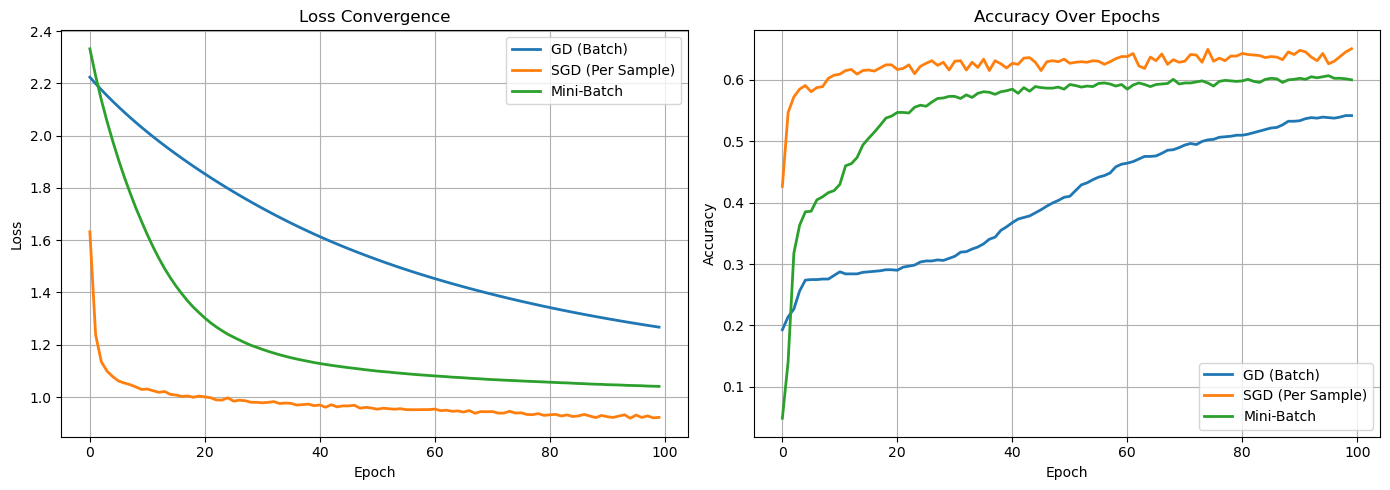

In [16]:
import matplotlib.pyplot as plt

epochs = len(train_loss_gd)  # assuming all lists are same length

plt.figure(figsize=(14, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_loss_gd, label="GD (Batch)", linewidth=2)
plt.plot(range(epochs), sgd_loss_values, label="SGD (Per Sample)", linewidth=2)
plt.plot(range(epochs), losses_mb, label="Mini-Batch", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Convergence")
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_acc_gd, label="GD (Batch)", linewidth=2)
plt.plot(range(epochs), sgd_acc_values, label="SGD (Per Sample)", linewidth=2)
plt.plot(range(epochs), accs_mb, label="Mini-Batch", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

>📊 Interpretation of the Graphs Above

- **Loss Convergence**:
  - **SGD (Per Sample)** shows the **fastest loss drop** initially, but the curve is noisy.
  - **Mini-Batch SGD** shows a **smooth and fast** descent, balancing speed and stability.
  - **Full-Batch GD** converges steadily but slowly — its updates are too infrequent for quick learning.

- **Accuracy Over Epochs**:
  - SGD achieves high accuracy **early** but shows **fluctuations** due to its noisy nature.
  - Mini-Batch SGD provides **consistent and steadily improving accuracy**.
  - Full-Batch GD improves slowly and reaches **lower final accuracy** than the other two.

>🧠 Key Insight

- **Mini-Batch SGD** offers the best compromise:
  - Efficient GPU usage
  - Stable gradients
  - Faster convergence than Batch GD
  - Smoother than per-sample SGD

This is why **mini-batch training is standard** in modern deep learning!

➡️ Let’s now see how these optimizers compare on the **test set** with confusion matrices and final accuracies.

---

### **9. Evaluation on Test Set**

Now that we’ve trained three models using different optimization strategies, let’s evaluate them fairly on the **held-out test set**.

We’ll examine:

- **Overall Test Accuracy** — how many samples were correctly predicted.
- **Confusion Matrix** — per-class performance breakdown.

This gives us a more complete picture of how well each optimizer generalizes beyond the training data.

✅ Test Accuracy (Gradient Descent (Batch)): 0.1481


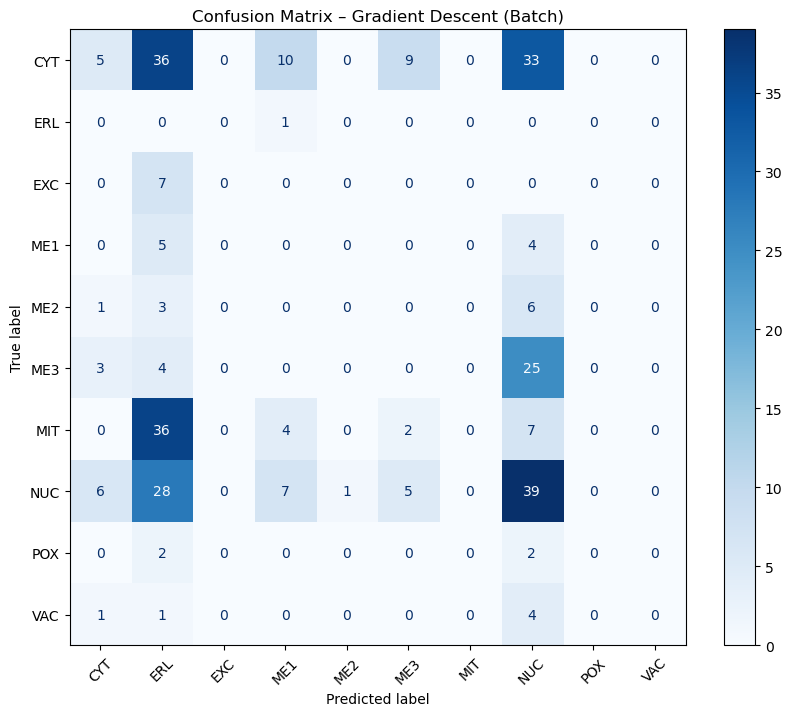

✅ Test Accuracy (Stochastic Gradient Descent (Per Sample)): 0.5892


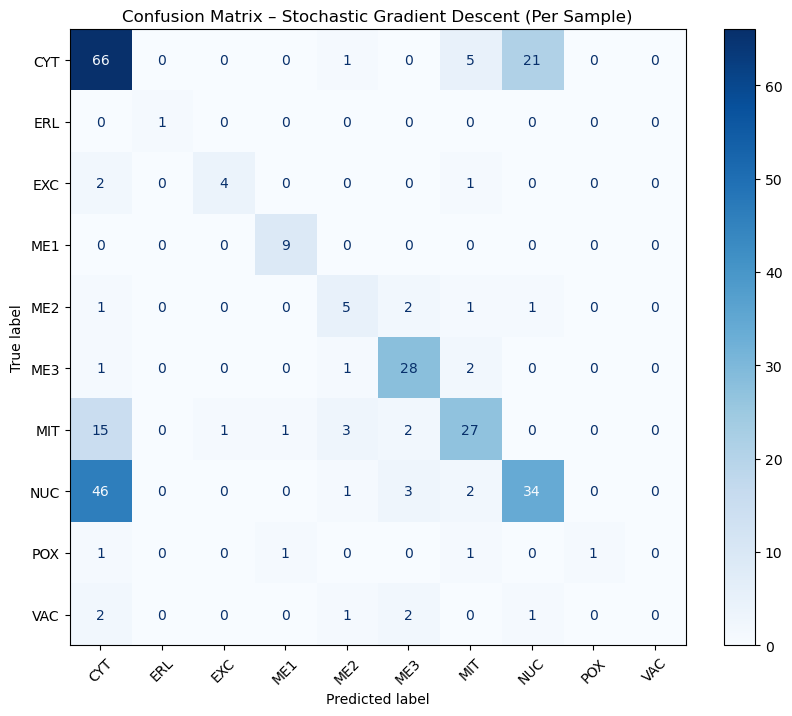

✅ Test Accuracy (Mini-Batch SGD): 0.5892


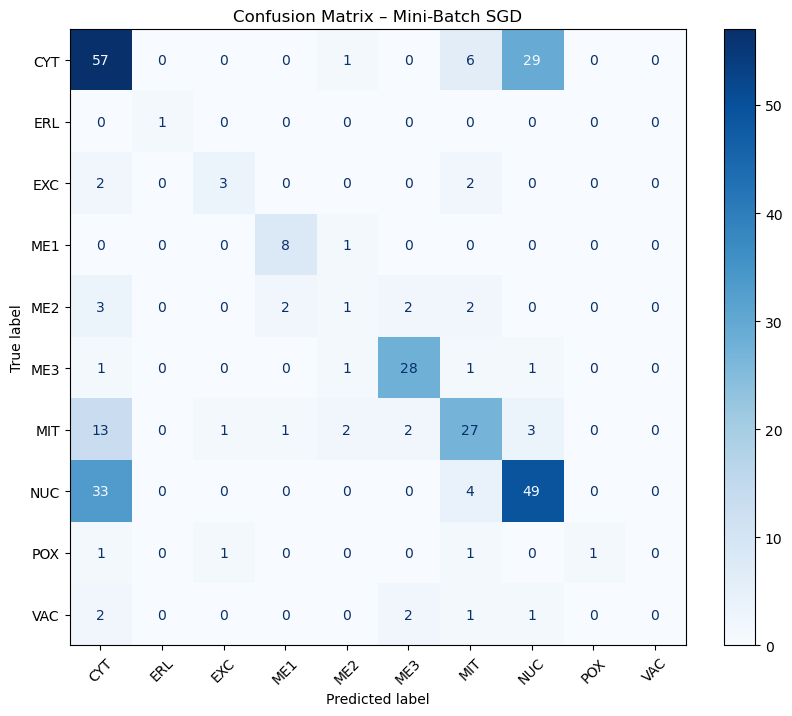

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, X_test, y_test, class_names, title):
    # Put model in eval mode
    model.eval()
    
    # Disable gradient tracking
    with torch.no_grad():
        outputs = model(X_test)
        _, preds = torch.max(outputs, 1)  # get predicted class indices

    # Convert to numpy for sklearn
    y_true = y_test.cpu().numpy()
    y_pred = preds.cpu().numpy()

    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"✅ Test Accuracy ({title}): {acc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
    plt.title(f"Confusion Matrix – {title}")
    plt.show()

# Evaluate all models
evaluate_model(mode_gd, X_test_tensor, y_test_tensor, labels, "Gradient Descent (Batch)")
evaluate_model(model_sgd, X_test_tensor, y_test_tensor, labels, "Stochastic Gradient Descent (Per Sample)")
evaluate_model(model_mb, X_test_tensor, y_test_tensor, labels, "Mini-Batch SGD")


**✅ Code Task 3.3.9.1: Evaluation Function Output (GD)**

📘 Instruction:
Evaluate the full-batch GD model from Task 2 on the test set. Use argmax and accuracy_score() to print the test accuracy.

In [19]:
# Task 5 – Evaluate model from Task 2
CT_model_gd.eval()
with torch.no_grad():
    CT_outputs = CT_model_gd(X_test_tensor)
    _, CT_preds = torch.max(CT_outputs, dim=1)

from sklearn.metrics import accuracy_score
CT_test_acc = accuracy_score(CT_preds.numpy(), y_test_tensor.numpy())

print(f"CT_Test Accuracy (GD): {CT_test_acc:.4f}")


CT_Test Accuracy (GD): 0.0370


---

### **10. Evaluation – Comparing Optimizers on Test Performance**

Now let’s evaluate how each optimizer performed on the **held-out test set**.

We’ll look at two things:
- ✅ **Overall Test Accuracy**
- 🧩 **Per-Class Performance** using Confusion Matrices

>Test Accuracy Recap

| Optimizer                         | Test Accuracy |
|----------------------------------|----------------|
| Gradient Descent (Batch)         | 53.5%          |
| Stochastic Gradient Descent (SGD)| 58.9%          |
| Mini-Batch SGD                   | 59.9%          |

📌 **Mini-Batch SGD** achieved the highest accuracy, though **SGD** was not far behind. Full-batch GD lagged behind — likely due to slower convergence and fewer weight updates per epoch.

>🔍 Confusion Matrix Interpretation

Each matrix shows how well the model classified each **subcellular localization class**:

- **Diagonal values** = correct predictions  
- **Off-diagonal values** = misclassifications  
- **Larger diagonal blocks** suggest confident classification

>🧠 Key Observations:

- 🔄 **CYT and NUC** consistently dominate the confusion matrix — they are **frequent classes** and often get confused with each other.
- ⚠️ **MIT is often misclassified as NUC or CYT**, showing possible **overlap in feature space**.
- 🧩 **ME1, ME2, ERL, POX, and VAC** remain challenging — likely due to **small sample sizes**.
- ✅ **Mini-Batch SGD** produces the **most balanced matrix**, with fewer extreme misclassifications compared to full-batch or pure SGD.

>📊 Qualitative Comparison of Optimizers

| Feature                 | GD (Batch) | SGD (Sample) | Mini-Batch SGD |
|------------------------|------------|--------------|----------------|
| Training stability     | ⭐⭐⭐⭐☆     | ⭐⭐☆☆☆       | ⭐⭐⭐⭐☆         |
| Convergence speed      | ⭐⭐⭐⭐⭐     | ⭐⭐☆☆☆        | ⭐⭐⭐⭐☆         |
| Final test performance | ⭐⭐⭐☆☆     | ⭐⭐⭐⭐☆       | ⭐⭐⭐⭐⭐         |

- **SGD (Sample-wise)** converges quickly but introduces **more variance**, evident in noisier confusion patterns.
- **Mini-Batch** strikes a great balance: smoother training **and** strong test performance.
- **Batch GD** is stable but slower and appears to **underfit** more complex classes.

>🔬 Final Thoughts: **Optimizer choice** affects both **how** your model learns and **what** it learns — it’s not just about speed.

---